# 😴 Multi-Day Sleep Analysis 💤

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


## Define day / days

In [2]:
from functions.load_data import load_single_date, load_date_range, get_ordinal_suffix

✅ Data loading functions defined


In [29]:
# ===== ANALYSIS MODE =====
ANALYSIS_MODE = 'multi'  # 'single' or 'multi'

# ===== SINGLE DAY CONFIGURATION =====
TARGET_DATE = '2026-01-12'  # Date to analyze (YYYY-MM-DD)

# ===== MULTI-DAY CONFIGURATION =====
START_DATE = '2026-01-16'   # Start date (YYYY-MM-DD)
END_DATE = '2026-01-19'     # End date (YYYY-MM-DD)

# ===== DATA CONFIGURATION =====
PARQUET_PATH = '../data'  # Data directory
TIMEZONE = 'Europe/London'

In [30]:
# Load data based on analysis mode
if ANALYSIS_MODE == 'single':
    dfs = load_single_date(TARGET_DATE, PARQUET_PATH, TIMEZONE)
    print(f"\n📊 Data Summary for {TARGET_DATE}:")
else:
    dfs = load_date_range(START_DATE, END_DATE, PARQUET_PATH, TIMEZONE)
    print(f"\n📊 Data Summary for {START_DATE} to {END_DATE}:")

print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")

print(f"\n✅ Data loaded successfully")

📥 Loading data for 2026-01-16 to 2026-01-19...
   ✅ Loaded 20 measurement types
   💾 Memory used: 45.3 MB

📊 Data Summary for 2026-01-16 to 2026-01-19:
HeartRate_Intraday             | 150063 records
Steps_Intraday                 |   5760 records
GPS                            |   7501 records
SleepLevels                    |    148 records
HRV                            |      4 records
BreathingRate                  |      4 records
SkinTemperature                |      4 records
SPO2_Daily                     |      3 records
Activity-minutesSedentary      |      4 records
Activity-minutesLightlyActive  |      4 records
Activity-minutesFairlyActive   |      4 records
Activity-minutesVeryActive     |      4 records
Activity-steps                 |      4 records
Activity-calories              |      4 records
Activity-distance              |      4 records
HR_Zones                       |      4 records
RestingHR                      |      4 records
SleepSummary                   |

In [31]:
# Parse TARGET_DATE and create formatted version
date_obj = datetime.strptime(TARGET_DATE, '%Y-%m-%d')
day = date_obj.day
suffix = get_ordinal_suffix(day)
formatted_date = date_obj.strftime(f'%A {day}{suffix} %B %Y')

In [32]:
formatted_date

'Monday 12th January 2026'

## Load dfs

In [33]:
df_sleep_levels = dfs.get('SleepLevels')
df_sleep_summary = dfs.get('SleepSummary')
df_skin_temp = dfs.get('SkinTemperature')
df_spo2 = dfs.get('SPO2_Daily')
df_steps_intra = dfs.get('Steps_Intraday')

In [34]:
from functions.sleep_helpers import *

In [35]:
# Prepare sleep data (calculate end times)
if not df_sleep_levels.empty and 'duration_seconds' in df_sleep_levels.columns:
    df_sleep_levels['end_time'] = df_sleep_levels['time'] + pd.to_timedelta(df_sleep_levels['duration_seconds'], unit='s')

if not df_sleep_summary.empty and 'endTime' in df_sleep_summary.columns:
    # Create end_time column from endTime
    df_sleep_summary['end_time'] = pd.to_datetime(df_sleep_summary['endTime'])
    if df_sleep_summary['end_time'].dt.tz is None:
        df_sleep_summary['end_time'] = df_sleep_summary['end_time'].dt.tz_localize('UTC')
    df_sleep_summary['end_time'] = df_sleep_summary['end_time'].dt.tz_convert(TIMEZONE)

if not df_sleep_levels.empty:
    df_sleep_levels['level_name'] = df_sleep_levels['level'].map(LEVEL_DECODE)

print("✅ Sleep data prepared")

✅ Sleep data prepared


In [36]:
# Sleep Overview
if not df_sleep_summary.empty:
    sleep_date = pd.to_datetime(TARGET_DATE).date()
    
    # Get skin_temp and spo2 for this date
    skin_temp = df_skin_temp['nightlyRelative'].iloc[0] if not df_skin_temp.empty else None
    
    if not df_spo2.empty:
        spo2_avg = df_spo2['avg'].iloc[0]
        spo2_min = df_spo2['min'].iloc[0]
        spo2_max = df_spo2['max'].iloc[0]
        spo2_str = f"💨 SpO2 (Blood Oxygen Saturation) avg: {spo2_avg:.1f}%, max: {spo2_max:.1f}%, min: {spo2_min:.1f}%"
    else:
        spo2_str = "💨 SpO2: N/A"
    
    total_asleep_today = 0
    main_sleep_today = 0
    nap_sleep_today = 0
    
    for idx, row in df_sleep_summary.sort_values('time').iterrows():
        start = row['time']
        end = row.get('end_time', start + pd.Timedelta(minutes=row['minutesAsleep'] + row.get('minutesAwake', 0)))
        is_main = row.get('isMainSleep', 'Unknown')
    
    # Total summary header
    total_hours = int(total_asleep_today // 60)
    total_mins = int(total_asleep_today % 60)
    main_hours = int(main_sleep_today // 60)
    main_mins = int(main_sleep_today % 60)
    nap_hours = int(nap_sleep_today // 60)
    nap_mins = int(nap_sleep_today % 60)

    if ANALYSIS_MODE == 'single':
        print("=" * 60)
        print(f"📅 Sleep Date:  {formatted_date}")
        print("-" * 60)
        if skin_temp is not None:
            print(f"\n🌡️ Skin temperature: {skin_temp}")
        print(f"{spo2_str} \n")
        print("=" * 60)
    else:
        None
    
    for idx, row in df_sleep_summary.sort_values('time').iterrows():
        is_main = row.get('isMainSleep', 'Unknown')
        session_type = "🌙 MAIN SLEEP" if is_main == 'True' else "💤 NAP"
        
        start = row['time']
        end = row.get('end_time', start + pd.Timedelta(minutes=row['minutesAsleep'] + row.get('minutesAwake', 0)))
        
        asleep_hr = row['minutesAsleep'] / 60
        awake_min = row.get('minutesAwake', 0)
        efficiency = row.get('efficiency', 0)
        minutes_in_bed = int(row['minutesInBed'])
        hours_in_bed = minutes_in_bed // 60
        mins_in_bed = minutes_in_bed % 60
        deep = row.get('minutesDeep', 0)
        light = row.get('minutesLight', 0)
        rem = row.get('minutesREM', 0)
        
        print(f"\n{session_type}")
        print("-" * 60)
        print(
            f"🕒 To Bed:      {start.strftime('%H:%M on %A %dth %B')}\n"
            f"🕓 Up & Atom:   {end.strftime('%H:%M on %A %dth %B')}\n"
            f"⏱️ Duration:    {hours_in_bed}h {mins_in_bed}m ({minutes_in_bed} min)\n"
            f"😴 Asleep:      {asleep_hr:.2f} hrs ({row['minutesAsleep']:.0f} min)\n"
            f"👁️ Awake:       {awake_min:.0f} min\n"
            f"⚡ Efficiency:  {efficiency:.0f}%\n"
            f"\n💤 Sleep Stages:\n"
            f"   Deep:  {deep:.0f} min ({deep/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   Light: {light:.0f} min ({light/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   REM:   {rem:.0f} min ({rem/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)"
        )
        print("\n" + "=" * 60)
else:
    print("❌ No sleep summary data available")


🌙 MAIN SLEEP
------------------------------------------------------------
🕒 To Bed:      20:48 on Thursday 15th January
🕓 Up & Atom:   05:49 on Friday 16th January
⏱️ Duration:    9h 1m (541 min)
😴 Asleep:      7.15 hrs (429 min)
👁️ Awake:       112 min
⚡ Efficiency:  79%

💤 Sleep Stages:
   Deep:  97 min (22.6%)
   Light: 292 min (68.1%)
   REM:   39 min (9.1%)


🌙 MAIN SLEEP
------------------------------------------------------------
🕒 To Bed:      21:24 on Friday 16th January
🕓 Up & Atom:   05:58 on Saturday 17th January
⏱️ Duration:    8h 34m (514 min)
😴 Asleep:      6.10 hrs (366 min)
👁️ Awake:       148 min
⚡ Efficiency:  71%

💤 Sleep Stages:
   Deep:  82 min (22.4%)
   Light: 186 min (50.8%)
   REM:   98 min (26.8%)


🌙 MAIN SLEEP
------------------------------------------------------------
🕒 To Bed:      00:26 on Sunday 18th January
🕓 Up & Atom:   11:22 on Sunday 18th January
⏱️ Duration:    10h 56m (656 min)
😴 Asleep:      9.03 hrs (542 min)
👁️ Awake:       113 min
⚡ Efficie

In [37]:
if ANALYSIS_MODE == 'single':
    # Main Sleep Timeline
    if not df_sleep_levels.empty and not df_sleep_summary.empty:
        print("\n🌙 Main Sleep Timeline")
        print("-" * 70)
        fig = plot_sleep_timeline(df_sleep_levels, df_sleep_summary, formatted_date)
        if fig: plt.show()

    # Hourly Steps Distribution
    if not df_steps_intra.empty:
        print("\n👟 Hourly Steps Distribution")
        print("-" * 70)
        fig = plot_steps_hour(df_steps_intra)
        if fig: plt.show()
    else:
        print("⚠️  No steps data available for hourly activity heatmap")

In [38]:
if ANALYSIS_MODE == 'single':
    if not df_sleep_levels.empty and not df_sleep_summary.empty:
        print("\n💤 Nap Analysis")
        print("-" * 70)
        fig = plot_naps_timeline(df_sleep_levels, df_sleep_summary, formatted_date)
        if fig: plt.show()

In [39]:
if ANALYSIS_MODE == 'single':
    if not df_sleep_summary.empty:
        print("\n📊 Main Sleep Composition")
        print("-" * 70)
        fig = plot_sleep_stages_pie(df_sleep_levels, df_sleep_summary, formatted_date)
        if fig: plt.show()

In [40]:
# ============================================================================
# MULTI-DAY SLEEP TRENDS
# ============================================================================

def plot_multi_day_sleep_timeline(df_sleep_levels, df_sleep_summary, start_date, end_date):
    """
    Plot state timeline for multiple days showing both main sleeps and naps.
    Each day gets its own row in the timeline.
    """
    if df_sleep_levels.empty or df_sleep_summary.empty:
        print("❌ No sleep data found")
        return None

    # Generate date range
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    num_days = len(dates)

    # Create figure with one row per day
    fig, axes = plt.subplots(num_days, 1, figsize=(18, 3 * num_days), sharex=False)
    if num_days == 1:
        axes = [axes]

    for idx, date in enumerate(dates):
        ax = axes[idx]
        date_str = date.strftime('%Y-%m-%d')

        # Define 24-hour window for this date (midnight to midnight)
        start_time = pd.Timestamp(date, tz=TIMEZONE)
        end_time = start_time + pd.Timedelta(days=1)

        # Get all sleep sessions for this date (main + naps)
        # Filter summary to get sessions that overlap with this day
        summary_for_day = df_sleep_summary.copy()
        summary_for_day['time'] = pd.to_datetime(summary_for_day['time'])
        summary_for_day['end_time'] = pd.to_datetime(summary_for_day['end_time'])

        # Get sessions that overlap with this day's window
        sessions = summary_for_day[
            (summary_for_day['time'] < end_time) &
            (summary_for_day['end_time'] > start_time)
        ]

        if sessions.empty:
            # No sleep data for this day
            ax.text(0.5, 0.5, 'No sleep data',
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=12, style='italic', color='gray')
            ax.set_xlim(start_time, end_time)
            ax.set_ylim(-0.5, 0.5)
            ax.set_yticks([])
            title = f'{date.strftime("%A, %B %d, %Y")} - No Data'
            ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            continue

        # Prepare sleep level data for this time window
        levels = prepare_sleep_data(df_sleep_levels, df_sleep_summary, start_time, end_time)

        if not levels.empty:
            plot_sleep_bars(ax, levels)

        # Add labels for each sleep session
        for _, session in sessions.iterrows():
            session_start = session['time']
            session_end = session['end_time']
            is_main = session.get('isMainSleep', 'True') == 'True'

            # Clip times to the current day's window for visualization
            display_start = max(session_start, start_time)
            display_end = min(session_end, end_time)

            label_text = "Main Sleep" if is_main else "Nap"
            duration_min = session.get('minutesInBed', 0)

            # Add vertical line at start
            ax.axvline(display_start, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

            # Add label above the timeline
            label_y_pos = 1.1
            ax.text(display_start, label_y_pos,
                   f"{label_text}\n{display_start.strftime('%H:%M')} | {duration_min:.0f}min\n\n",
                   ha='left', va='bottom', fontsize=9, fontweight='bold',
                   transform=ax.get_xaxis_transform())

        # Format the axis for this day
        formatter = DateFormatter('%H:%M', tz=TIMEZONE)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(HourLocator(interval=2, tz=TIMEZONE))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

        ax.set_xlim(start_time, end_time)
        ax.set_ylim(-0.5, 0.5)
        ax.set_yticks([])

        # Build title with session count
        main_count = len(sessions[sessions.get('isMainSleep', 'True') == 'True'])
        nap_count = len(sessions[sessions.get('isMainSleep', 'True') == 'False'])

        title_parts = [date.strftime("%A, %B %d, %Y")]
        if main_count > 0:
            title_parts.append(f"{main_count} main sleep")
        if nap_count > 0:
            title_parts.append(f"{nap_count} nap{'s' if nap_count > 1 else ''}")

        title = " - ".join(title_parts)
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)

        ax.grid(True, axis='x', alpha=0.6, linestyle='--')
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Add legend only on first plot
        if idx == 0:
            add_sleep_legend(ax, location='upper right')

    plt.suptitle(f'Multi-Day Sleep Timeline: {start_date} to {end_date}',
                fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()

    return fig

print("✅ Multi-day analysis and activity pattern functions defined")

✅ Multi-day analysis and activity pattern functions defined



MULTI-DAY SLEEP ANALYSIS: 2026-01-16 to 2026-01-19



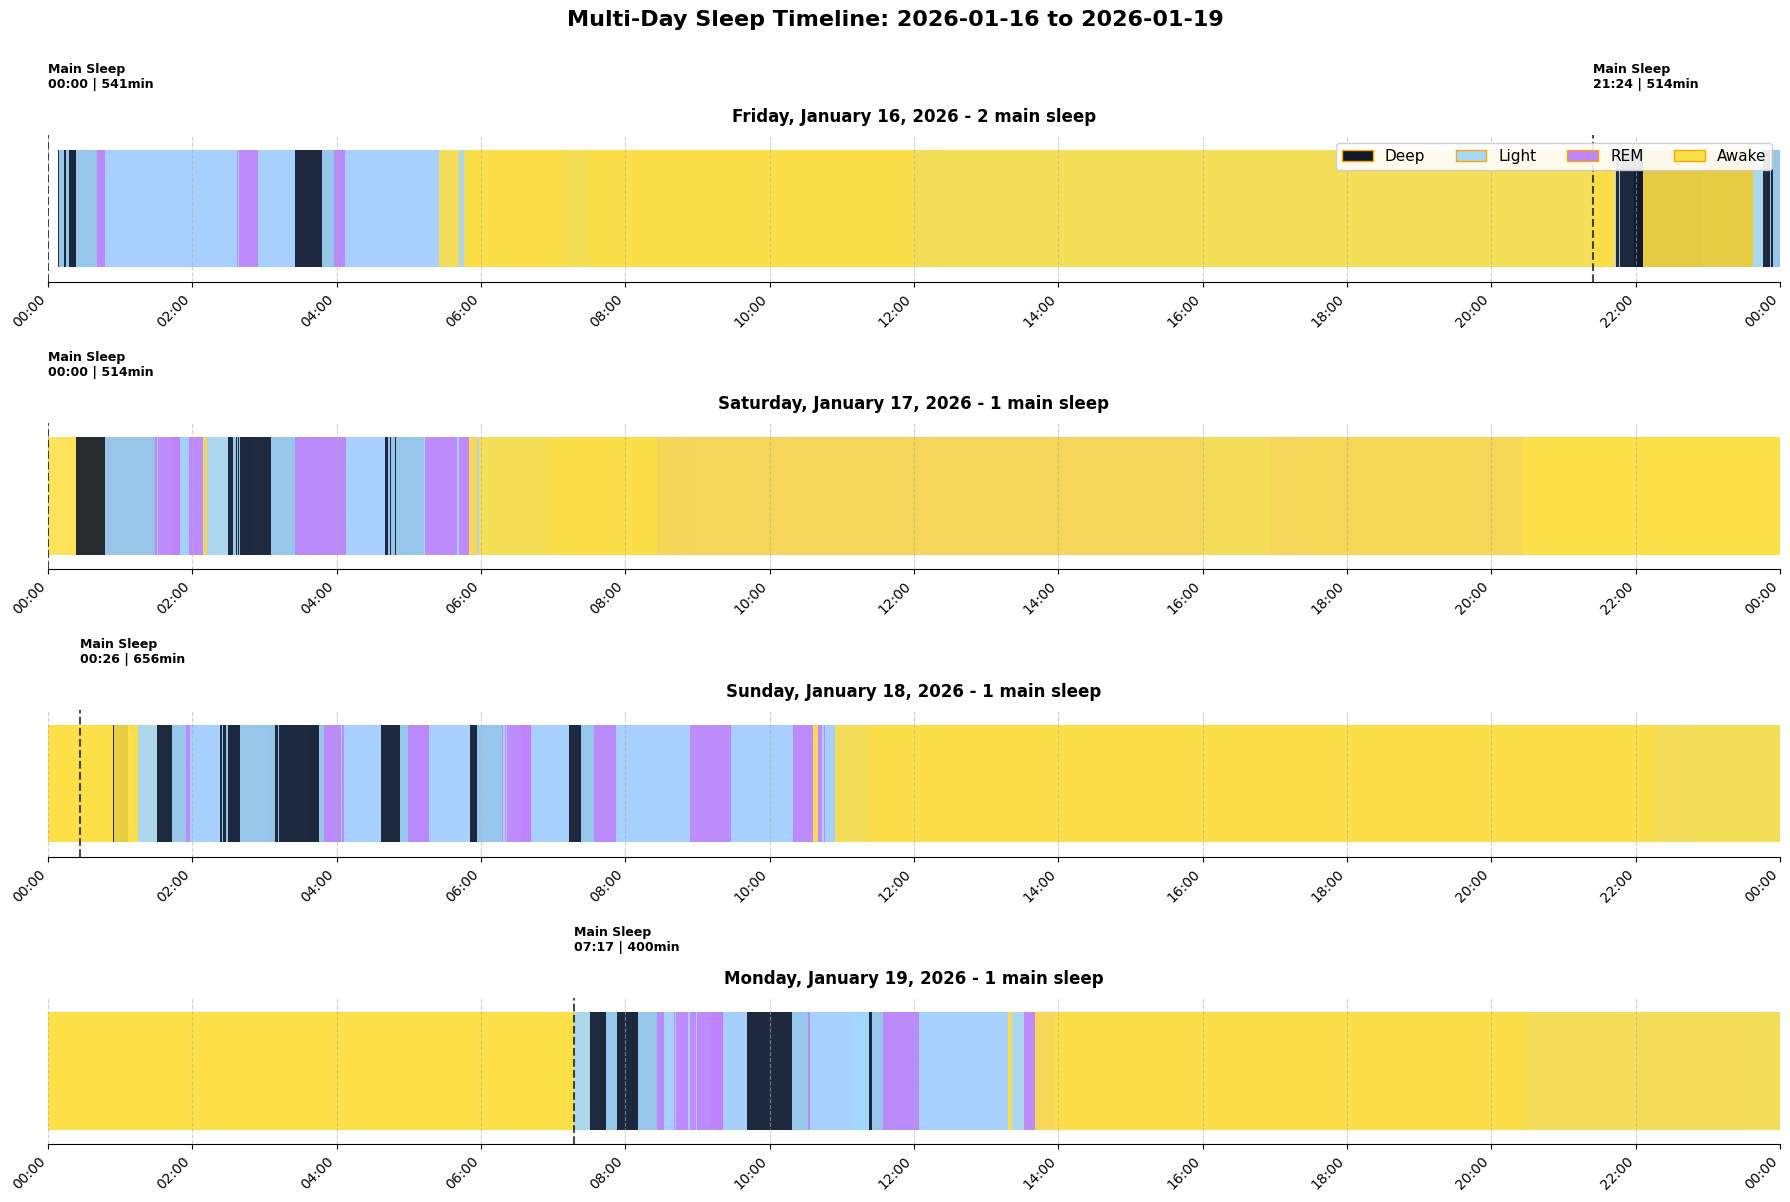

In [41]:
if ANALYSIS_MODE == 'multi':
    print(f"\n{'='*70}")
    print(f"MULTI-DAY SLEEP ANALYSIS: {START_DATE} to {END_DATE}")
    print(f"{'='*70}\n")
    
    # Multi-Day Sleep Timeline (Main Sleeps + Naps)
    if not df_sleep_levels.empty and not df_sleep_summary.empty:
        # print("\n🌙 Multi-Day Sleep State Timeline")
        # print("-" * 70)
        # print("Shows all sleep sessions (main sleeps and naps) across multiple days\n")
        fig = plot_multi_day_sleep_timeline(df_sleep_levels, df_sleep_summary, START_DATE, END_DATE)
        if fig: plt.show()
    else:
        print("❌ Insufficient data for multi-day timeline")

else:
    print("ℹ️  Multi-day analysis skipped (mode is 'single')")